В этой записной книжке показано, как изначально были получены данные для учебника по подписям pytorch.

Запуск этого скрипта не требуется для выполнения основного задания, поскольку __вам будут предоставлены предварительно обработанные данные__, созданные этой записной книжкой. Сам сценарий занимает часы

Однако, если кто-то хочет реализовать, например. внимательные субтитры с вниманием к более ранним уровням сети ИЛИ попробуйте другую сетевую архитектуру, предлагается изменить этот код по желанию.
Рекомендуются графические процессоры, высокоскоростной доступ в Интернет и около 50 ГБ дискового пространства.

Тут минут 12

In [ ]:
# Получение данных:
# скачать материалы с http://cocodataset.org/#download
!curl http://images.cocodataset.org/zips/train2017.zip > train2017.zip
!curl http://images.cocodataset.org/zips/val2017.zip > val2017.zip
!curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip > annotations_trainval2017.zip

!unzip annotations_trainval2017.zip
!rm -f annotations_trainval2017.zip
!unzip train2017.zip > log
!rm -f train2017.zip
!unzip val2017.zip > log
!rm -f val2017.zipy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.0G  100 18.0G    0     0  47.0M      0  0:06:31  0:06:31 --:--:-- 38.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  777M  100  777M    0     0  45.3M      0  0:00:17  0:00:17 --:--:-- 46.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  42.7M      0  0:00:05  0:00:05 --:--:-- 48.0M
Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2

In [ ]:
# sanity check
!du -h --max-depth=1 .

108K	./.config
19G	./train2017
788M	./val2017
796M	./annotations
55M	./sample_data
21G	.


In [ ]:
%tensorflow_version 1.x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%env CUDA_VISIBLE_DEVICES=1,2,3
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

env: CUDA_VISIBLE_DEVICES=1,2,3


In [ ]:
# you may need to !pip install pycocotools
from torchvision.datasets import coco
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])


coco_train = coco.CocoCaptions("./train2017/", "./annotations/captions_train2017.json", transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=coco_train, batch_size=32,  shuffle=False, num_workers=4)

loading annotations into memory...
Done (t=1.33s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.models.inception import Inception3
from warnings import warn
class BeheadedInception3(Inception3):
    """ Вроде torchvision.models.inception.Inception3 но голова идет отдельно """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)  # before_pool # 8 x 8 x 2048
        
        x = F.avg_pool2d(x, kernel_size=8) # 1 x 1 x 2048
        
        x_for_capt = x = x.view(x.size(0), -1)  # after_pool # 2048
       
        x = self.fc(x) # logits # 1000 (это количество входных данных для вашего линейного слоя)
        
        return x_for_attn, x_for_capt, x

In [ ]:
from torch.utils.model_zoo import load_url
model= BeheadedInception3(transform_input=True)

inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
model.load_state_dict(load_url(inception_url))

#model = nn.DataParallel(model.train(False).cuda())
model = nn.DataParallel(model.train(False).cpu())

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


# Санитарная проверка

Тестовый запуск NN на одной партии. Метки NN не должны быть полностью абсурдными.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


NN shapes
before_pool: (32, 2048, 8, 8)
after_pool: (32, 2048)
logits: (32, 1000)
# 1
torch.Size([3, 299, 299])


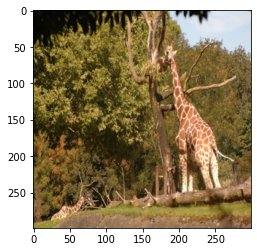

Captions
('A giraffe eating food from the top of the tree.', 'A giraffe standing up nearby a tree ', 'A giraffe mother with its baby in the forest.', 'Two giraffes standing in a tree filled area.', 'A giraffe standing next to a forest filled with trees.')
NN classes
['cheetah, chetah, Acinonyx jubatus', 'crane', 'leopard, Panthera pardus', 'tile roof', 'tiger cat']
# 10
torch.Size([3, 299, 299])


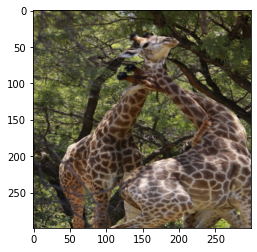

Captions
('A couple of giraffe snuggling each other in a forest.', 'A couple of giraffe standing next to some trees.', 'Two Zebras seem to be embracing in the wild. ', 'Two giraffes hang out near trees and nuzzle up to each other.', 'The two giraffes appear to be hugging each other.')
NN classes
['rock python, rock snake, Python sebae', 'loggerhead, loggerhead turtle, Caretta caretta', 'boa constrictor, Constrictor constrictor', 'diamondback, diamondback rattlesnake, Crotalus adamanteus', 'bustard']
# 19
torch.Size([3, 299, 299])


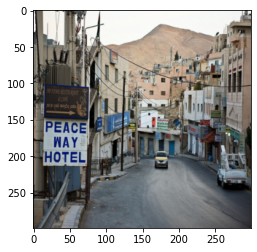

Captions
('There is a street lined with packed buildings', 'There is a car driving down a street with buildings on each side.', 'A street sign and a car on the road.', 'This is a view of a quaint city street.', 'A city street with a sign that reads "Peace Way Hotel".')
NN classes
['tobacco shop, tobacconist shop, tobacconist', 'bookshop, bookstore, bookstall', 'carton', 'streetcar, tram, tramcar, trolley, trolley car', 'street sign']
# 28
torch.Size([3, 299, 299])


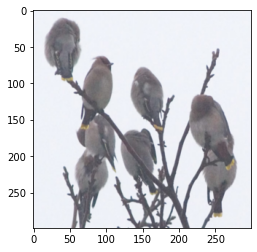

Captions
('Birds perch on a bunch of twigs in the winter.', 'A number of small birds sitting at the top of a bare tree.', 'Many birds perched on the limbs of a tree.', 'Eight birds perch on a branch on an overcast day.', 'Several birds are sitting on small tree branches.')
NN classes
['hip, rose hip, rosehip', 'robin, American robin, Turdus migratorius', 'brambling, Fringilla montifringilla', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird']


In [ ]:
img_batch, capt_batch = next(iter(data_loader))

# Пакет титров транспонирован в нашей версии. Проверьте, верно ли то же самое для вас
capt_batch = list(zip(*capt_batch))
img_batch = Variable(img_batch, volatile=True)


#img_batch = tuple(zip(*img_batch))

vec_batch_for_attn, vec_batch, logits_batch  = [var.cpu().data.numpy() for var in model(img_batch)]

print("NN shapes")
print('before_pool:', np.shape(vec_batch_for_attn))
print('after_pool:', np.shape(vec_batch))
print('logits:', np.shape(logits_batch))


# class labels
import requests
#LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
LABELS_URL = 'https://gist.githubusercontent.com/doosik71/8d1ddd645fee6afa9e4a3e429e5c4b9f/raw/2f02234d93b3b994e40073646400d06da167f13e/imagenet_labels.json'
labels = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

for i in range(1, 30, 9):
    print("#", i)
    print(img_batch[i].shape)
    plt.imshow(img_batch[i].data.cpu().numpy().transpose([1,2,0]))
    plt.show()
    print('Подписи из датасета')
    print(capt_batch[i])

    top_ix = (-logits_batch[i]).argsort() # Возвращает индексы, которые будут сортировать массив. np.argsort(-x) возвращает по убываию
    print('NN classes')
    print(list(map(labels.get, top_ix[:5]))) # берем топ 5 самых популярных индексов и выводим слова LABELS_URL

# Фактическое преобразование данных

Примечание: эта часть может потреблять много оперативной памяти. Если вы немного ограничены:
* Не храните векторы, которые вам не нужны (например, vectors_before_pool, если нет внимания)
* Сохраняйте все на диск каждые K итераций и освобождайте память.
     * Их придется читать вручную.

In [ ]:
from tqdm import tqdm
vectors_before_pool, vectors, logits, captions = [], [], [], []
iter = 0
for img_batch, capt_batch in tqdm(data_loader):
    iter +=1
    print('Iteration' , iter)
    capt_batch = list(zip(*capt_batch))
    #img_batch = tuple(zip(*img_batch))
    img_batch = Variable(img_batch, volatile=True) #  имеют тот же API, что и тензоры PyTorch: (почти) 
    #любую операцию, которую вы можете выполнять с тензором, вы также можете выполнять с Variable
    print(np.asarray(capt_batch).shape , img_batch.shape)
    vec_batch_for_attn, vec_batch, logits_batch  = [var.cpu().data.numpy() for var in model(img_batch)]
    
    
    logits.extend([vec for vec in logits_batch]) # extend Дополняет список элементами из указанного объекта.
    captions.extend(capt_batch)
    vectors.extend([vec for vec in vec_batch])
    ## ПРЕДУПРЕЖДЕНИЕ! Если у вас мало оперативной памяти, прокомментируйте эту строку.
    vectors_before_pool.extend([vec for vec in vec_batch_for_attn])

    if iter==1:
        np.save("vectors_before_pool.npy", vectors_before_pool)
        np.save("logits.npy", logits)
        np.save("vectors.npy", vectors)

    if iter%2 ==0:

      oll_vectors_before_pool = np.load("vectors_before_pool.npy")
      oll = np.concatenate((oll_vectors_before_pool,vectors_before_pool), axis=0)
      np.save("vectors_before_pool.npy", oll)
      del oll_vectors_before_pool,vectors_before_pool , oll

      oll_logits = np.load("logits.npy")
      oll = np.concatenate((oll_logits,logits), axis=0)
      np.save("logits.npy", oll)
      del oll_logits,logits , oll

      oll_vectors= np.load("vectors.npy")
      oll = np.concatenate((oll_vectors,vectors), axis=0)
      np.save("vectors.npy", oll)
      del oll_vectors, oll , vectors

      vectors_before_pool, vectors, logits, captions = [], [], [], []
      #break

    

  0%|          | 0/3697 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration 1
(32, 5) torch.Size([32, 3, 299, 299])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
  0%|          | 1/3697 [00:17<17:47:09, 17.32s/it]

Iteration 2
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 2/3697 [00:26<12:40:41, 12.35s/it]

Iteration 3
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 3/3697 [00:34<10:56:55, 10.67s/it]

Iteration 4
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 4/3697 [00:43<10:14:16,  9.98s/it]

Iteration 5
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 5/3697 [00:52<9:47:57,  9.56s/it] 

Iteration 6
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 6/3697 [01:01<9:35:57,  9.36s/it]

Iteration 7
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 7/3697 [01:10<9:33:25,  9.32s/it]

Iteration 8
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 8/3697 [01:19<9:28:51,  9.25s/it]

Iteration 9
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 9/3697 [01:28<9:19:10,  9.10s/it]

Iteration 10
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 10/3697 [01:37<9:20:49,  9.13s/it]

Iteration 11
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 11/3697 [01:46<9:13:46,  9.01s/it]

Iteration 12
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 12/3697 [01:55<9:18:15,  9.09s/it]

Iteration 13
(32, 5) torch.Size([32, 3, 299, 299])


  0%|          | 13/3697 [02:04<9:48:43,  9.59s/it]


RuntimeError: ignored

In [ ]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

captions_tokenized = [[' '.join(filter(len, tokenizer.tokenize(cap.lower()))) 
                           for cap in img_captions]
                                for img_captions in tqdm(captions)]

100%|██████████| 384/384 [00:00<00:00, 6618.99it/s]


In [ ]:
i = 123
print("Original:\n%s\n\n" % '\n'.join(captions[i]))
print("Tokenized:\n%s\n\n"% '\n'.join(captions_tokenized[i]))

Original:
A young man riding a skateboard down a ramp.
A person standing on a skateboard and skating at a park.
A teenager riding a skateboard at a skate park.
A man riding a skateboard on a ramp.
A kid on a skate board riding on a ramp.


Tokenized:
a young man riding a skateboard down a ramp .
a person standing on a skateboard and skating at a park .
a teenager riding a skateboard at a skate park .
a man riding a skateboard on a ramp .
a kid on a skate board riding on a ramp .




# Save everything
May take a couple of minutes depending on hdd/sdd speed.

In [ ]:
!mkdir handout

np.save("./handout/image_codes.npy", np.asarray(vectors))
np.save("./handout/image_codes_for_attn.npy", np.asarray(vectors_before_pool))
np.save('./handout/image_logits.npy', np.asarray(logits))

import json
with open('./handout/captions.json', 'w') as f_cap:
    json.dump(captions, f_cap)
with open('./handout/captions_tokenized.json', 'w') as f_cap:
    json.dump(captions_tokenized, f_cap)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model, '/content/drive/MyDrive/учеба/ВЫШКА/НЕЙРО_СЕТИ/model_preprocess_data_3_domashka.pkl')

In [ ]:
!rm *.npy

In [ ]:
# sanity check
!du -h --max-depth=1 .
!ls -lht handout